Import Libraries

In [20]:
# Core imports
import pandas as pd
import numpy as np
import pickle
from collections import Counter

# Preprocessing & splitting
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold

# Sampling
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics & evaluation
from sklearn.metrics import (
    roc_curve, auc, f1_score, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    average_precision_score
)

from sklearn.calibration import CalibratedClassifierCV

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# TabNet
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

Reading Input files

In [21]:
Final_Dataset_Provider_Train = pd.read_csv('C:/Users/Asus/Desktop/Final_Implementation/Processed/Final_Train_adv.csv')
Final_Dataset_Provider_Test = pd.read_csv('C:/Users/Asus/Desktop/Final_Implementation/Processed/Final_Test_adv.csv')

In [22]:
Final_Dataset_Provider_Train.columns

Index(['Unnamed: 0.1', 'Provider', 'PotentialFraud', 'Unnamed: 0',
       'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'Hospitalization_Duration', 'Claim_Period', 'ExtraClaimDays',
       'Inpatient_or_Outpatient',
       ...
       'PerProviderClmDiagnosisCode_4_count_ClaimID',
       'PerProviderClmDiagnosisCode_5_count_ClaimID',
       'PerProviderClmDiagnosisCode_6_count_ClaimID',
       'PerProviderDiagnosisGroupCode_count_ClaimID', 'Gender_0', 'Gender_1',
       'Race_1', 'Race_2', 'Race_3', 'Race_5'],
      dtype='object', length=249)

In [23]:
Final_Dataset_Provider_Train.drop(['Unnamed: 0.1','Unnamed: 0'],axis=1,inplace=True)
Final_Dataset_Provider_Test.drop(['Unnamed: 0.1','Unnamed: 0'],axis=1,inplace=True)

In [24]:
Final_Dataset_Provider_Train.shape

(5410, 247)

Separate independent and dependent variables and standardizing data

In [25]:
# Seperate dependent and independent variables
X_train = Final_Dataset_Provider_Train.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Train['PotentialFraud']
X_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [26]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)
X_train_std = standard_scaler.transform(X_train)
X_test_std = standard_scaler.transform(X_test)

In [27]:
X_train.columns

Index(['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'Hospitalization_Duration', 'Claim_Period', 'ExtraClaimDays',
       'Inpatient_or_Outpatient', 'RenalDiseaseIndicator',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       ...
       'PerProviderClmDiagnosisCode_4_count_ClaimID',
       'PerProviderClmDiagnosisCode_5_count_ClaimID',
       'PerProviderClmDiagnosisCode_6_count_ClaimID',
       'PerProviderDiagnosisGroupCode_count_ClaimID', 'Gender_0', 'Gender_1',
       'Race_1', 'Race_2', 'Race_3', 'Race_5'],
      dtype='object', length=245)

Splitting the data into train and test for model building and predicted

In [28]:
# 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_train_std, y_train,
    test_size=0.4,
    stratify=y_train,
    random_state=42
)

# then 20% val, 20% internal-test
X_val, X_test_int, y_val, y_test_int = train_test_split(
    X_temp,  y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Shapes →",
      "Train:", X_train.shape,
      "Val:",   X_val.shape,
      "Test:",  X_test_int.shape)


Shapes → Train: (3246, 245) Val: (1082, 245) Test: (1082, 245)


In [29]:
counter = Counter(y_train)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.37% and Non-Fraud Percentage = 90.63%


Oversample the data using SMOTE to make it 20:80 ratio

In [30]:
oversample = SMOTE(sampling_strategy=0.25, random_state=42)
X_tr_os, y_tr_os = oversample.fit_resample(X_train, y_train)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 19.99% and Non-Fraud Percentage = 80.01%


Helper Functions (ROC, Thresholding, Confusion Matrix, Validation)

In [31]:
def pred_prob(clf, data):
    y_pred = clf.predict_proba(data)
    return y_pred[:,1] if y_pred.shape[1] > 1 else y_pred.ravel()

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    plt.plot(train_fpr, train_tpr, label=f"Train AUC={auc(train_fpr, train_tpr):.4f}")
    plt.plot(test_fpr,  test_tpr,  label=f"Test  AUC={auc(test_fpr,  test_tpr):.4f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(False)
    plt.show()

def find_best_threshold(thresholds, fpr, tpr):
    return thresholds[np.argmax(tpr*(1-fpr))]

def apply_threshold(proba, thresh):
    return [1 if p >= thresh else 0 for p in proba]

def draw_confusion(best_t, X_tr, X_te, y_tr, y_te, y_tr_proba, y_te_proba):
    tr_pred = apply_threshold(y_tr_proba, best_t)
    te_pred = apply_threshold(y_te_proba, best_t)
    
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    for ax, actual, pred, title in [
        (axes[0], y_tr, tr_pred, 'Train CM'),
        (axes[1], y_te, te_pred, 'Test  CM')
    ]:
        cm = confusion_matrix(actual, pred)
        sns.heatmap(cm, annot=True, fmt="d", ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.show()
    return tr_pred, te_pred

def validate_model(clf, X_tr, X_te, y_tr, y_te):
    # get predicted probabilities
    y_tr_proba = pred_prob(clf, X_tr)
    y_te_proba = pred_prob(clf, X_te)

    # determine best threshold on training ROC
    tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, y_tr_proba)
    best_t = find_best_threshold(tr_thresh, tr_fpr, tr_tpr)

    # apply threshold
    y_tr_pred = apply_threshold(y_tr_proba, best_t)
    y_te_pred = apply_threshold(y_te_proba, best_t)

    # compute metrics on test fold
    acc    = accuracy_score(y_te, y_te_pred)
    prec   = precision_score(y_te, y_te_pred, zero_division=0)
    rec    = recall_score(y_te, y_te_pred, zero_division=0)
    f1     = f1_score(y_te, y_te_pred)
    rocauc = auc(*roc_curve(y_te, y_te_proba)[:2])
    prauc  = average_precision_score(y_te, y_te_proba)

    # print results
    print(f"Test Accuracy : {acc:.4f}")
    print(f"Test Precision: {prec:.4f}")
    print(f"Test Recall   : {rec:.4f}")
    print(f"Test F1 Score : {f1:.4f}")
    print(f"Test ROC-AUC  : {rocauc:.4f}")
    print(f"Test PR-AUC   : {prauc:.4f}")
    print(f"Best Threshold: {best_t:.4f}")

    # visuals
    draw_confusion(best_t, X_tr, X_te, y_tr, y_te, y_tr_proba, y_te_proba)
    draw_roc(tr_fpr, tr_tpr, *roc_curve(y_te, y_te_proba)[:2])

    return {
        'Accuracy':    acc,
        'Precision':   prec,
        'Recall':      rec,
        'F1 Score':    f1,
        'ROC-AUC':     rocauc,
        'PR-AUC':      prauc,
        'Best Thresh': best_t
    }



Logistic Regression Model

Best params: {'C': np.float64(0.1), 'penalty': 'l2'}
Test Accuracy : 0.8688
Test Precision: 0.4089
Test Recall   : 0.9109
Test F1 Score : 0.5644
Test ROC-AUC  : 0.9425
Test PR-AUC   : 0.7609
Best Threshold: 0.1200


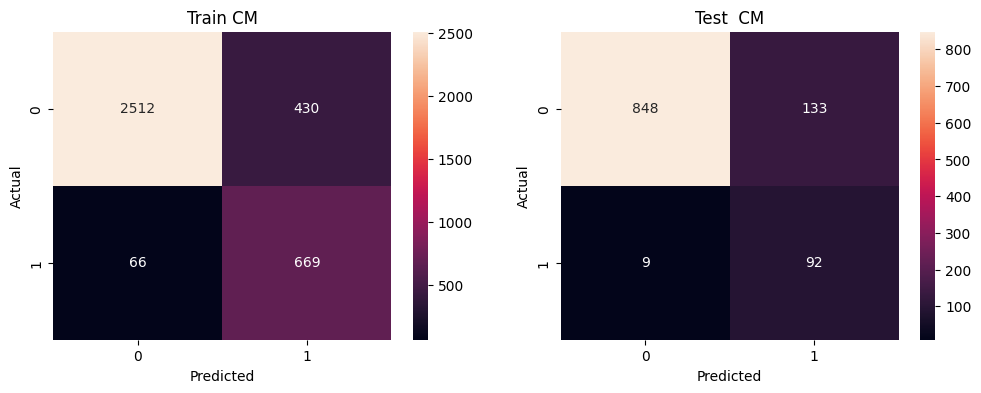

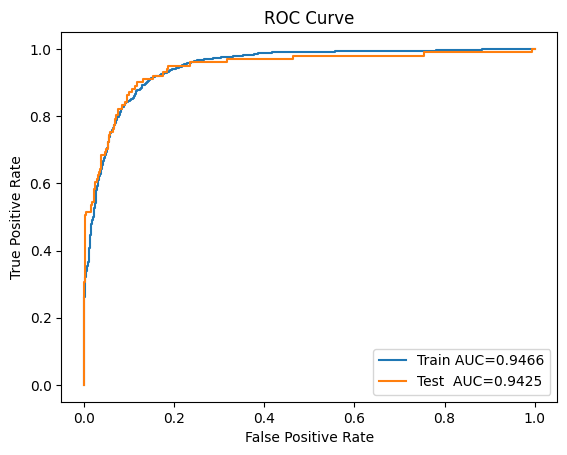

In [32]:
# Hyperparameter tuning
lr = LogisticRegression(max_iter=1000)
param_grid = {'C': np.logspace(-3,3,7), 'penalty': ['l2']}
lr_cv = GridSearchCV(lr, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
lr_cv.fit(X_tr_os, y_tr_os)
print("Best params:", lr_cv.best_params_)

# Final model
best_lr = LogisticRegression(**lr_cv.best_params_, max_iter=1000).fit(X_tr_os, y_tr_os)
lr_metrics = validate_model(best_lr, X_tr_os, X_val, y_tr_os, y_val)



Decision Tree model

Best params: {'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 200}
Test Accuracy : 0.8678
Test Precision: 0.4037
Test Recall   : 0.8713
Test F1 Score : 0.5517
Test ROC-AUC  : 0.9376
Test PR-AUC   : 0.6499
Best Threshold: 0.2424


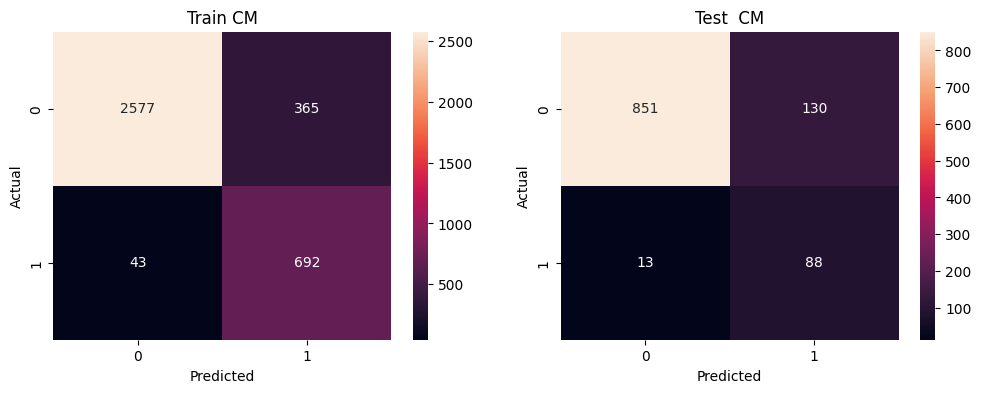

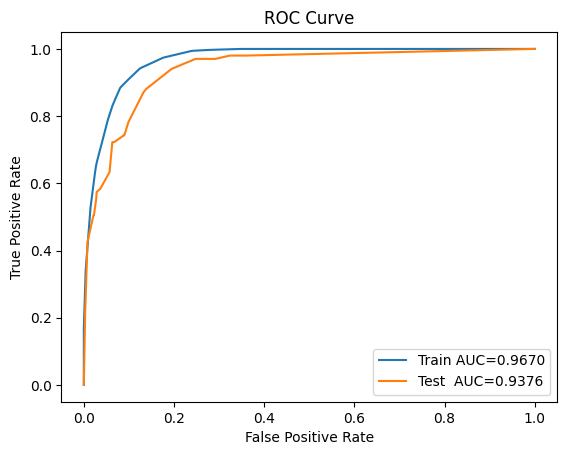

In [33]:
dt = DecisionTreeClassifier(random_state=42)
dt_params = {
    'criterion': ['gini','entropy'],
    'max_depth': [5,10,50,100,150,200,250,500],
    'min_samples_split': [5,10,50,100,150,200,250,500]
}
dt_cv = GridSearchCV(dt, dt_params, cv=3, scoring='roc_auc', n_jobs=-1)
dt_cv.fit(X_tr_os, y_tr_os)
print("Best params:", dt_cv.best_params_)

best_dt = DecisionTreeClassifier(**dt_cv.best_params_, random_state=42).fit(X_tr_os, y_tr_os)
dt_metrics = validate_model(best_dt, X_tr_os, X_val, y_tr_os, y_val)



Support Vector Classifier Model

c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'C': 0.5, 'dual': False, 'penalty': 'l1'}


c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Accuracy : 0.8882
Test Precision: 0.4479
Test Recall   : 0.8515
Test F1 Score : 0.5870
Test ROC-AUC  : 0.9356
Test PR-AUC   : 0.7676
Best Threshold: 0.1478


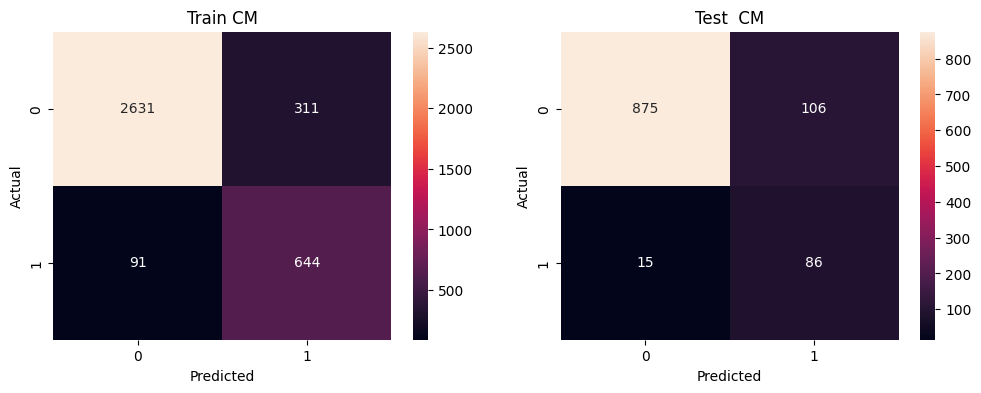

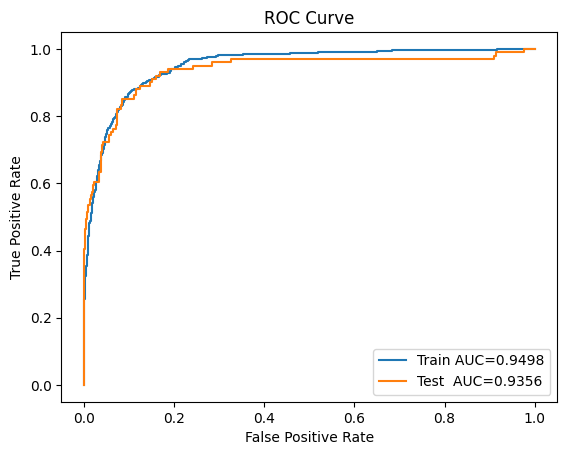

In [34]:
svc = LinearSVC(max_iter=5000)
svc_params = {'C': [0.5,1.0], 'penalty': ['l1','l2'], 'dual': [False]}
svc_cv = GridSearchCV(svc, svc_params, cv=5, scoring='roc_auc', n_jobs=-1)
svc_cv.fit(X_tr_os, y_tr_os)
print("Best params:", svc_cv.best_params_)

cal_svc = CalibratedClassifierCV(LinearSVC(**svc_cv.best_params_, max_iter=5000))
cal_svc.fit(X_tr_os, y_tr_os)
svc_metrics = validate_model(cal_svc, X_tr_os, X_val, y_tr_os, y_val)


Gaussian Naive Bayes Classifier Model

Test Accuracy : 0.8050
Test Precision: 0.3090
Test Recall   : 0.8812
Test F1 Score : 0.4576
Test ROC-AUC  : 0.8731
Test PR-AUC   : 0.4344
Best Threshold: 0.0000


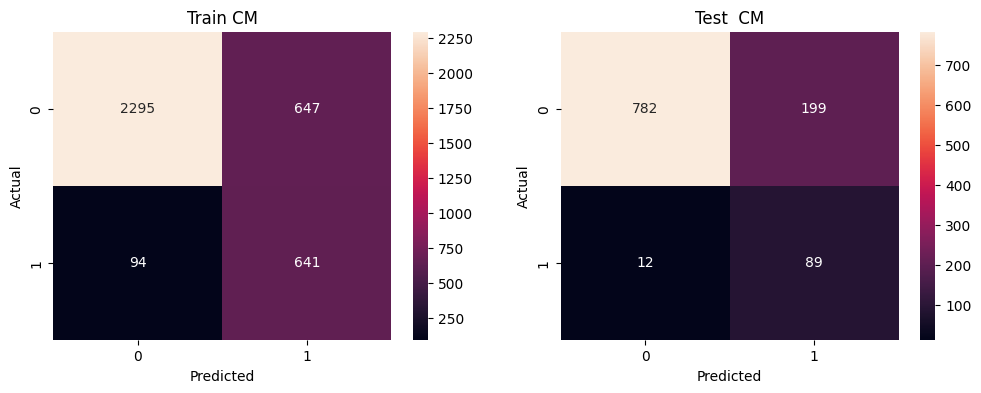

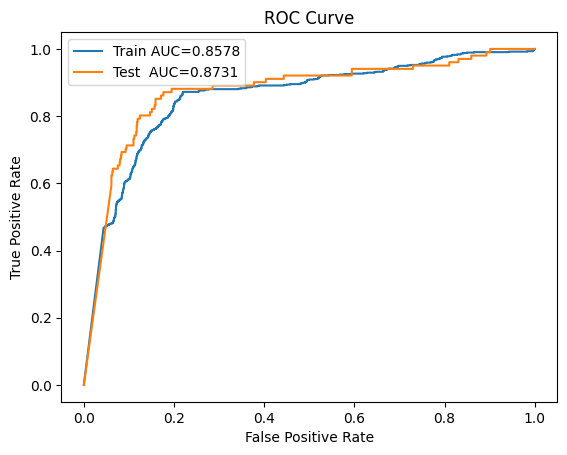

In [35]:
gnb = GaussianNB().fit(X_tr_os, y_tr_os)
nb_metrics = validate_model(gnb, X_tr_os, X_val, y_tr_os, y_val)



KNN

Best params: {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
Test Accuracy : 0.9335
Test Precision: 0.8372
Test Recall   : 0.3564
Test F1 Score : 0.5000
Test ROC-AUC  : 0.8942
Test PR-AUC   : 0.6221
Best Threshold: 1.0000


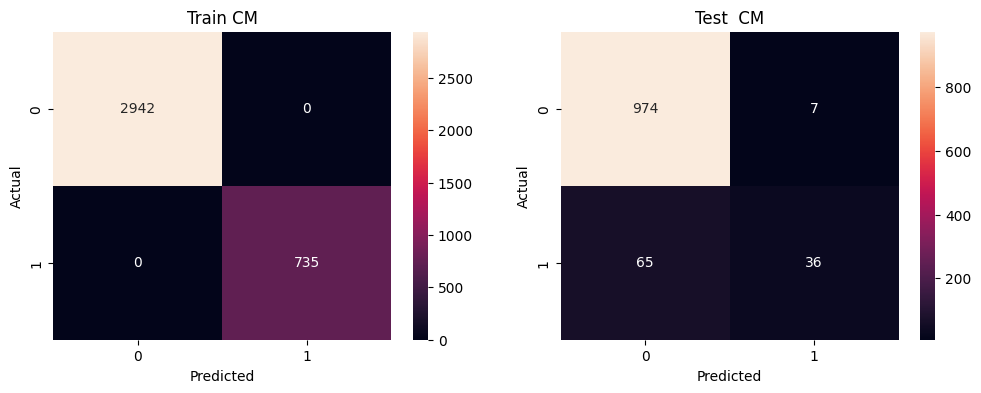

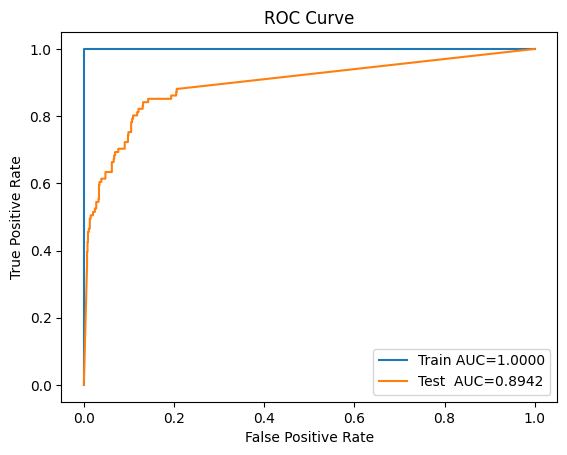

In [36]:
knn = KNeighborsClassifier()
knn_params = {'n_neighbors':[3,5,7,9],'weights':['uniform','distance'],'p':[1,2]}
knn_cv = GridSearchCV(knn, knn_params, cv=3, scoring='roc_auc', n_jobs=-1)
knn_cv.fit(X_tr_os, y_tr_os)
print("Best params:", knn_cv.best_params_)

best_knn = KNeighborsClassifier(**knn_cv.best_params_).fit(X_tr_os, y_tr_os)
knn_metrics = validate_model(best_knn, X_tr_os, X_val, y_tr_os, y_val)


Random Forest

Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy : 0.9399
Test Precision: 0.7432
Test Recall   : 0.5446
Test F1 Score : 0.6286
Test ROC-AUC  : 0.9462
Test PR-AUC   : 0.7429
Best Threshold: 0.5650


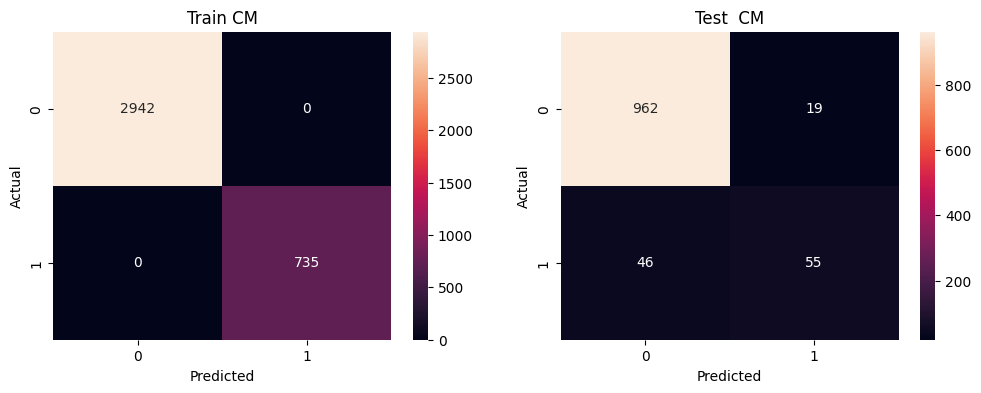

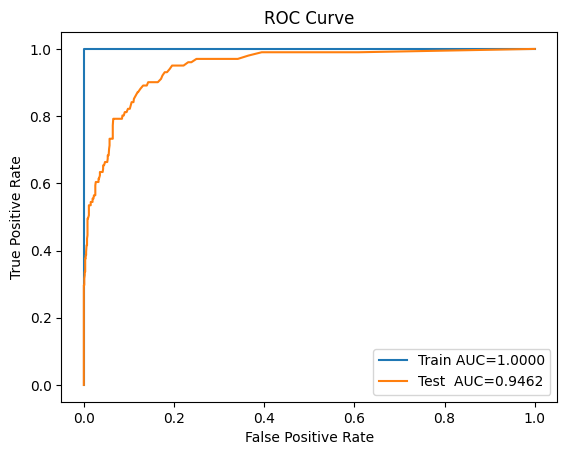

In [37]:
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100,200],
    'max_depth': [10,20,None],
    'min_samples_split': [2,5],
    'class_weight': ['balanced', None]
}
rf_cv = GridSearchCV(rf, rf_params, cv=3, scoring='roc_auc', n_jobs=-1)
rf_cv.fit(X_tr_os, y_tr_os)
print("Best params:", rf_cv.best_params_)

best_rf = rf_cv.best_estimator_
rf_metrics = validate_model(best_rf, X_tr_os, X_val, y_tr_os, y_val)



Neural Networks

c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Accuracy : 0.8826
Test Precision: 0.4369
Test Recall   : 0.8911
Test F1 Score : 0.5863
Test ROC-AUC  : 0.9419
Test PR-AUC   : 0.7609
Best Threshold: 0.2213


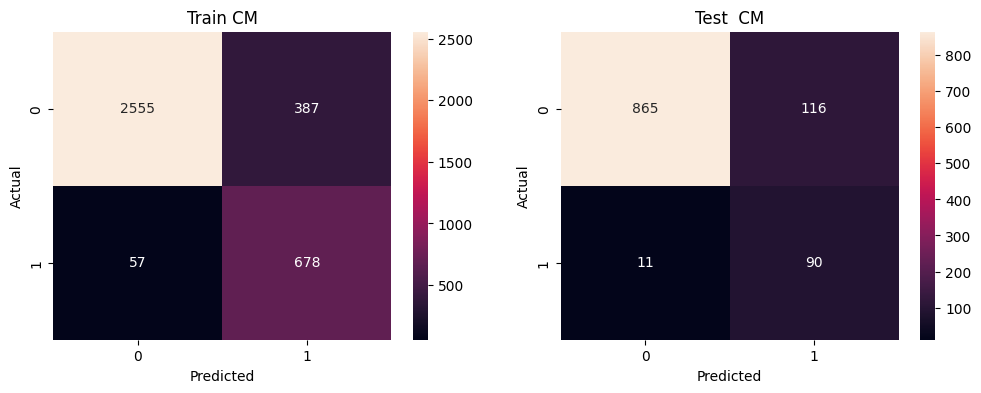

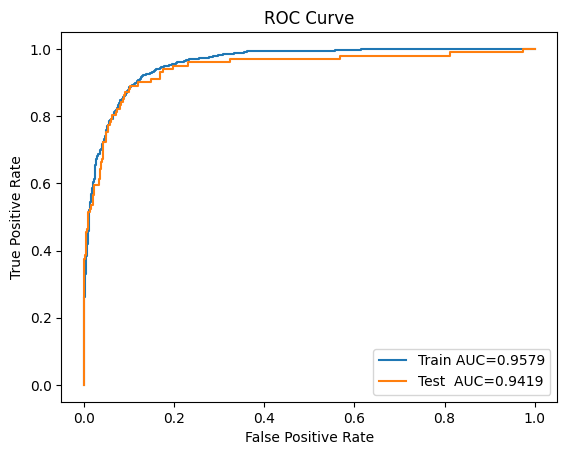

In [38]:
# Build
input_dim = X_tr_os.shape[1]
nn = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
nn.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
nn.fit(X_tr_os, y_tr_os, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Make predict_proba available
nn.predict_proba = lambda data: nn.predict(data)

# Validate the NN
nn_metrics = validate_model(nn, X_tr_os, X_val, y_tr_os, y_val)


CNN

c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Accuracy : 0.8993
Test Precision: 0.4787
Test Recall   : 0.8911
Test F1 Score : 0.6228
Test ROC-AUC  : 0.9371
Test PR-AUC   : 0.7574
Best Threshold: 0.2308


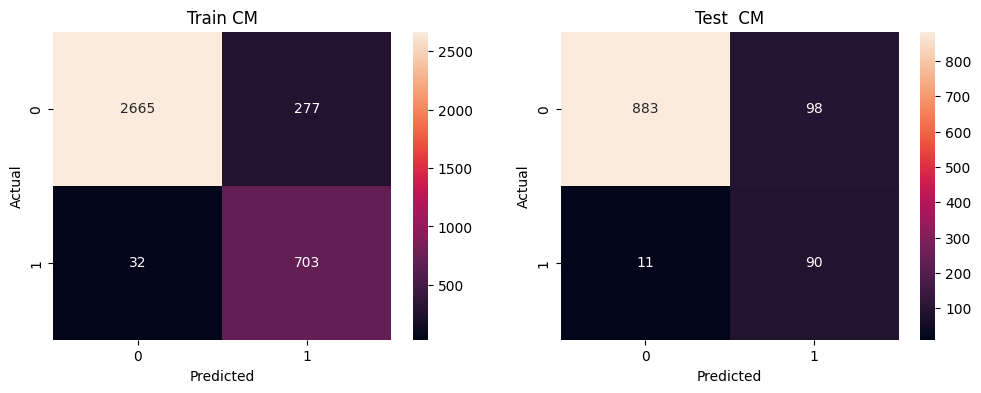

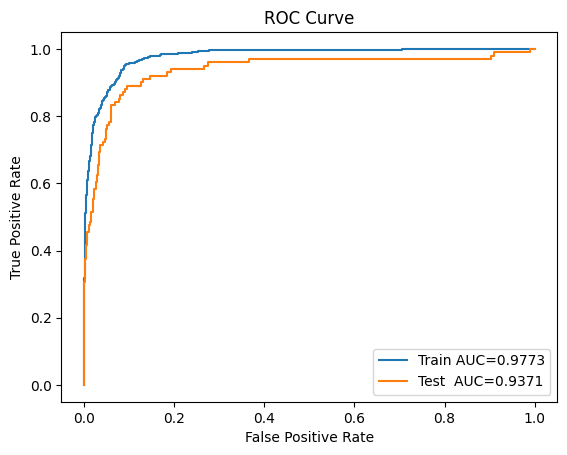

In [39]:
# Reshape
X_tr_cnn  = X_tr_os.reshape(-1, X_tr_os.shape[1], 1)
X_val_cnn = X_val.reshape(-1,   X_val.shape[1],   1)

# Build
cnn = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_tr_cnn.shape[1],1)),
    MaxPooling1D(2), Dropout(0.25),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'), Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
cnn.fit(
    X_tr_cnn, y_tr_os,
    epochs=50, batch_size=32,
    validation_data=(X_val_cnn, y_val),
    verbose=0
)

# Make predict_proba available
cnn.predict_proba = lambda data: cnn.predict(data)

# Validate on the 3D CNN inputs
cnn_metrics = validate_model(cnn, X_tr_cnn, X_val_cnn, y_tr_os, y_val)


TabNet

c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69469 | train_auc: 0.77787 | valid_auc: 0.7808  |  0:00:00s
epoch 1  | loss: 0.62161 | train_auc: 0.80721 | valid_auc: 0.79578 |  0:00:01s
epoch 2  | loss: 0.53251 | train_auc: 0.81784 | valid_auc: 0.78158 |  0:00:01s
epoch 3  | loss: 0.50167 | train_auc: 0.83629 | valid_auc: 0.84437 |  0:00:02s
epoch 4  | loss: 0.46477 | train_auc: 0.87307 | valid_auc: 0.90302 |  0:00:02s
epoch 5  | loss: 0.42489 | train_auc: 0.89162 | valid_auc: 0.92324 |  0:00:03s
epoch 6  | loss: 0.39113 | train_auc: 0.87753 | valid_auc: 0.91949 |  0:00:03s
epoch 7  | loss: 0.36666 | train_auc: 0.90396 | valid_auc: 0.92906 |  0:00:04s
epoch 8  | loss: 0.36878 | train_auc: 0.90783 | valid_auc: 0.92805 |  0:00:04s
epoch 9  | loss: 0.34786 | train_auc: 0.91165 | valid_auc: 0.91757 |  0:00:05s
epoch 10 | loss: 0.32155 | train_auc: 0.92129 | valid_auc: 0.93558 |  0:00:05s
epoch 11 | loss: 0.32195 | train_auc: 0.91271 | valid_auc: 0.90252 |  0:00:06s
epoch 12 | loss: 0.3103  | train_auc: 0.92038 | vali

c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test Accuracy : 0.8595
Test Precision: 0.3906
Test Recall   : 0.9010
Test F1 Score : 0.5449
Test ROC-AUC  : 0.9491
Test PR-AUC   : 0.7509
Best Threshold: 0.2564


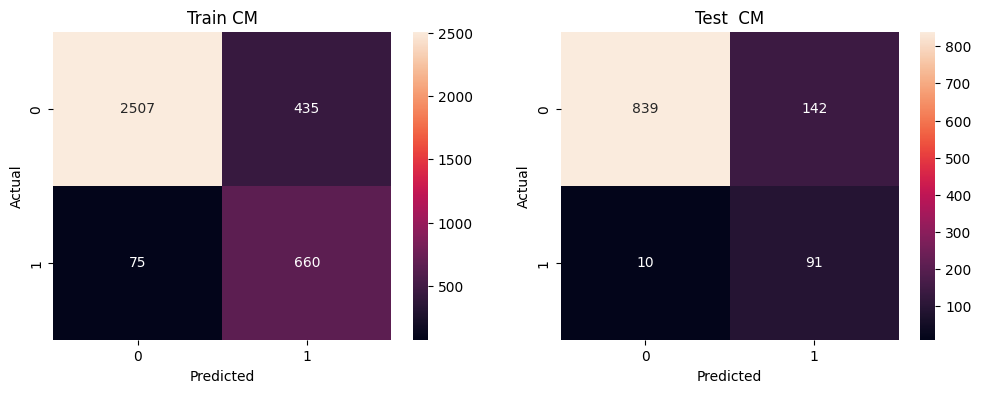

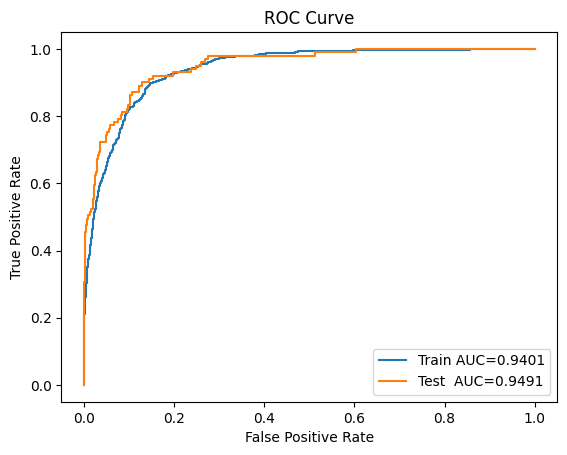

In [40]:
# Cell 17: TabNet (fixed)
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Configure (no categorical features here)
tabnet = TabNetClassifier(
    cat_idxs=[], cat_dims=[], cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size": 50, "gamma": 0.9},
    mask_type='sparsemax'
)

# Fit without the unsupported `verbose` kwarg
tabnet.fit(
    X_train=X_tr_os,
    y_train=y_tr_os,
    eval_set=[(X_tr_os, y_tr_os), (X_val, y_val)],
    eval_name=['train','valid'],
    eval_metric=['auc'],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Then validate TabNet on the train/validation split
tabnet_metrics = validate_model(tabnet, X_tr_os, X_val, y_tr_os, y_val)


Autoencoder

In [41]:
# --- Cell: Autoencoder Anomaly Detector ---
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score,
    precision_score, recall_score, average_precision_score
)

# 1. Only use non-fraud cases to train the autoencoder
X_norm = X_tr_os[y_tr_os == 0]

# 2. Build a simple dense autoencoder
input_dim = X_norm.shape[1]
inp       = Input(shape=(input_dim,))
enc       = Dense(64, activation='relu')(inp)
enc       = Dense(32, activation='relu')(enc)
dec       = Dense(64, activation='relu')(enc)
out       = Dense(input_dim, activation=None)(dec)

autoencoder = Model(inputs=inp, outputs=out)
autoencoder.compile(optimizer='adam', loss='mse')

# 3. Train on "normal" data only
autoencoder.fit(
    X_norm, X_norm,
    epochs=50,
    batch_size=32,
    validation_data=(X_val[y_val == 0], X_val[y_val == 0]),
    verbose=1
)

# 4. Compute a reconstruction-error threshold (95th percentile)
recon_train = autoencoder.predict(X_norm)
mse_train   = np.mean((X_norm - recon_train)**2, axis=1)
threshold   = np.percentile(mse_train, 95)

# 5. Score the validation set
recon_val    = autoencoder.predict(X_val)
mse_val      = np.mean((X_val - recon_val)**2, axis=1)
y_val_pred   = (mse_val > threshold).astype(int)

# 6. Compute all metrics
auc_auto = roc_auc_score(y_val, mse_val)
f1_auto  = f1_score(y_val, y_val_pred)
acc_auto = accuracy_score(y_val, y_val_pred)
prec_auto= precision_score(y_val, y_val_pred, zero_division=0)
rec_auto = recall_score(y_val, y_val_pred, zero_division=0)
prauc_auto = average_precision_score(y_val, mse_val)

# 7. Print them
print(f"Autoencoder Accuracy : {acc_auto:.4f}")
print(f"Autoencoder Precision: {prec_auto:.4f}")
print(f"Autoencoder Recall   : {rec_auto:.4f}")
print(f"Autoencoder F1 Score : {f1_auto:.4f}")
print(f"Autoencoder ROC-AUC  : {auc_auto:.4f}")
print(f"Autoencoder PR-AUC   : {prauc_auto:.4f}")
print(f"Autoencoder Threshold: {threshold:.4f}")

# 8. Store in the same dict format as the other models
autoenc_metrics = {
    'Accuracy':    acc_auto,
    'Precision':   prec_auto,
    'Recall':      rec_auto,
    'F1 Score':    f1_auto,
    'ROC-AUC':     auc_auto,
    'PR-AUC':      prauc_auto,
    'Best Thresh': threshold
}


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1086 - val_loss: 0.0127
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0046
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 12/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_lo

Summarize Results

In [42]:
from beautifultable import BeautifulTable

table = BeautifulTable()
table.column_headers = [
    "Model","Accuracy","Precision","Recall",
    "F1 Score","ROC-AUC","PR-AUC","Best Thresh"
]

all_metrics = {
    "LogReg":       lr_metrics,
    "DecisionTree": dt_metrics,
    "SVM":          svc_metrics,
    "NaiveBayes":   nb_metrics,
    "KNN":          knn_metrics,
    "RandomForest": rf_metrics,
    "NeuralNet":    nn_metrics,
    "CNN":          cnn_metrics,
    "TabNet":       tabnet_metrics,
    "Autoencoder":  autoenc_metrics
}

for name, m in all_metrics.items():
    row = [name] + [f"{m[col]:.4f}" for col in table.column_headers[1:]]
    table.append_row(row)

print(table)


+-------------+--------+---------+--------+--------+-------+--------+----------+
|    Model    | Accura | Precisi | Recall | F1 Sco | ROC-A | PR-AUC | Best Thr |
|             |   cy   |   on    |        |   re   |  UC   |        |   esh    |
+-------------+--------+---------+--------+--------+-------+--------+----------+
|   LogReg    | 0.869  |  0.409  | 0.911  | 0.564  | 0.943 | 0.761  |   0.12   |
+-------------+--------+---------+--------+--------+-------+--------+----------+
| DecisionTre | 0.868  |  0.404  | 0.871  | 0.552  | 0.938 |  0.65  |  0.242   |
|      e      |        |         |        |        |       |        |          |
+-------------+--------+---------+--------+--------+-------+--------+----------+
|     SVM     | 0.888  |  0.448  | 0.852  | 0.587  | 0.936 | 0.768  |  0.148   |
+-------------+--------+---------+--------+--------+-------+--------+----------+
| NaiveBayes  | 0.805  |  0.309  | 0.881  | 0.458  | 0.873 | 0.434  |   0.0    |
+-------------+--------+----

c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


Save & Reload Final Model

In [43]:
# --- Final model selection, retrain (optional), and save ---

import pickle

# 1) Build a map from model‐names to actual fitted objects
model_map = {
    "LogReg":       best_lr,
    "DecisionTree": best_dt,
    "SVM":          cal_svc,
    "NaiveBayes":   gnb,
    "KNN":          best_knn,
    "RandomForest": best_rf,
    "NeuralNet":    nn,
    "CNN":          cnn,
    "TabNet":       tabnet,
    "Autoencoder":  autoencoder
}

# 2) Pick the best model by PR-AUC from all_metrics
best_model_name = max(all_metrics, key=lambda name: all_metrics[name]['PR-AUC'])
best_score      = all_metrics[best_model_name]['PR-AUC']
print(f"Selected best model: {best_model_name} (PR-AUC = {best_score:.4f})")

#Pick & (optionally) retrain best_model on train+val
best_model = model_map[best_model_name]
X_combined = np.vstack([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])
best_model.fit(X_combined, y_combined)


Selected best model: SVM (PR-AUC = 0.7676)


c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV(estimator=LinearSVC(C=0.5, dual=False, max_iter=5000,
                                           penalty='l1'))

In [44]:
# 4) Save the selected model & scaler
with open('model_adv.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler_adv.pkl', 'wb') as f:
    pickle.dump(standard_scaler, f)

print("Model and scaler saved to disk.")

Model and scaler saved to disk.


Test Accuracy : 0.8632
Test Precision: 0.3946
Test Recall   : 0.8713
Test F1 Score : 0.5432
Test ROC-AUC  : 0.9317
Test PR-AUC   : 0.7195
Best Threshold: 0.0614


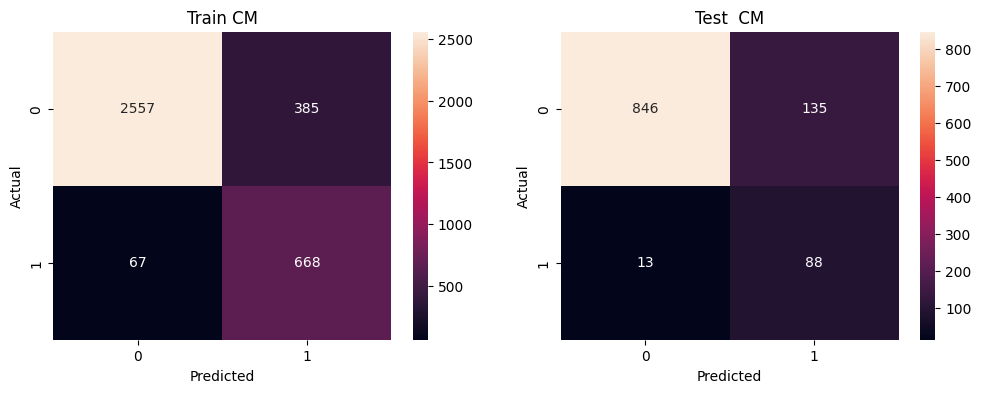

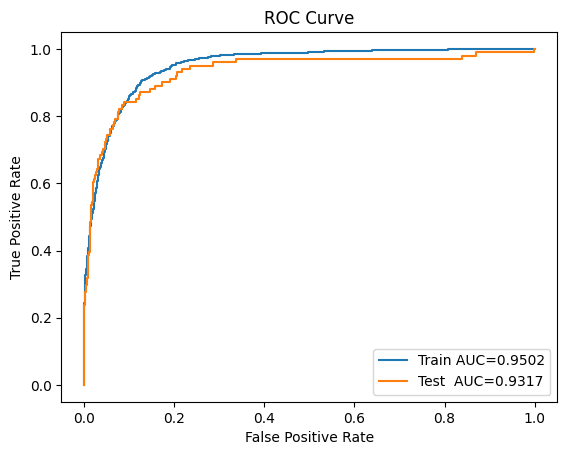


Internal Test Metrics:
Accuracy    : 0.8632
Precision   : 0.3946
Recall      : 0.8713
F1 Score    : 0.5432
ROC-AUC     : 0.9317
PR-AUC      : 0.7195
Best Thresh : 0.0614


In [45]:
# 3) Internal‐test evaluation
test_metrics = validate_model(best_model, X_tr_os, X_test_int, y_tr_os, y_test_int)
print("\nInternal Test Metrics:")
for k,v in test_metrics.items(): print(f"{k:12s}: {v:.4f}")


Fraud percentage in the model prediciton

In [46]:


# Predict on your held-out internal test set
y_test_pred = best_model.predict(X_test_int)
pred_rate   = (y_test_pred == 1).mean() * 100
print(f"Predicted Fraud Rate on internal test: {pred_rate:.2f}%")


Predicted Fraud Rate on internal test: 6.28%


In [47]:
#Production-Data 
df_prod = Final_Dataset_Provider_Test.drop(columns=['Provider'])
feats         = standard_scaler.transform(df_prod.values)
y_prod_pred   = best_model.predict(feats)
prod_rate     = (y_prod_pred == 1).mean() * 100
print(f"Predicted Fraud Rate in live data: {prod_rate:.2f}%")


Predicted Fraud Rate in live data: 4.36%


c:\Users\Asus\Desktop\Final_Implementation\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [49]:
import pickle

# 1) Load your best model and the scaler  
model  = pickle.load(open("model_adv.pkl",      "rb"))  
scaler = pickle.load(open("scaler_adv.pkl",     "rb"))  

# 2) Figure out how many inputs the scaler expects
if hasattr(scaler, "n_features_in_"):
    scaler_inputs = scaler.n_features_in_
else:
    # most sklearn‐style scalers expose .mean_ whose length == n_features
    scaler_inputs = scaler.mean_.shape[0]
print(f"Scaler expects : {scaler_inputs} features")

# 3) Figure out how many inputs the model expects
if hasattr(model, "n_features_in_"):
    print(f"Model expects  : {model.n_features_in_} features")
else:
    # fallback for e.g. TabNetClassifier
    print(f"Model ({type(model).__name__}) has no `n_features_in_`; "
          f"assuming {scaler_inputs} inputs")


Scaler expects : 245 features
Model expects  : 245 features
